## Notebook 16-05-19

Tom Verburg
10769633

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from model_functions import *
import pandas as pd
import itertools
from IPython.display import HTML, display
import tabulate
import sys
sys.path.insert(0, 'C:/Users/tom_v/Documents/Master/Thesis/Master-Thesis/research/pre-processing')
from pre_processing_functions import *
import re
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
base = os.getcwd().split('Master-Thesis')[0].replace('\\', '/')
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest, chi2
import operator
from gensim.sklearn_api import D2VTransformer
from IPython.display import display

C:\Users\tom_v\AppData\Local\Continuum\anaconda2\envs\PythonNieuw\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Overview of content 

In this notebook, the aim is to get an oversight of the achievements so far, as well as which things I still wish to approach. First off there is the EDA of the dataset used. This is filtered so that there are no duplicate pages, as well as all the split deed documents removed due to ambigous highlighting between documents. 

This ambigouity originates from the same documents being processed for different cases. This results in some highlights always being essential, whilst others which are case specific are not. This can be due to address specificiations, or whether there are certain exceptions to an address which do not apply to other splits in the document.

The ambigouity of the highlighting is not only reserved to the split documents. However, split documents are a main source ambigouity when it comes to inconsitency of highlights. Therefore, one question is:

**To what extent can the f1 measure go up(?) if split deeds are not included?**



Furthermore, due to there being a variety of hyperparameters to tune, the following question is posed:

**What values for the hyperparameters vocabulary size, minimal amount of document frequency and regularization value result in the best f1 for both TF and TFIDF vectorization for the binary classification task?**

To answer this question, grid search is performed for different hyperparameters for the cross fold classification pipeline.  The hyperparemeters which were tested were k (amount of features) and  min df (minimal amount of document frequency) for the vectorization method. This was either the TF or TFIDF. The final parameter tested was C (the regularization parameter) for the classifier (which in this case is always the logistic regression). This combination of different parameters resulted in 750 fits for both cross validation grid searches 

The answer to both questions can be seen in the result section of this notebook.

In [2]:
df_final = pd.read_pickle('complete_dataframe_tokenized_versions.pickle')
path_df_anno = base + '/Master-Thesis/research/pre-processing/df_anno_complete_dataset.pickle'

## EDA 

Here the complete dataset is described, without any of the files filtered out. It initially consists of a set of 100000 (binary labelled) pages spread over 4000 different documents, but because there are many pages which are the same these were eliminated from the dataset, as well as pages belonging to splitsing aktes. Following this, all the pages were vectorized using different methods and then a logistic regression model was applied to see how well these different vectors performed. Firstly, the EDA of the processed dataset used is shown below.

In [22]:
print('Size dataframe:                  ' + str(len(df_overlap)))
print('Unique filenames:                ' + str(len(set(df_overlap.filename))))
print('Unique pages:                    ' + str(len(set(df_overlap.text_string))))
print('Unique words complete tokenized: ' + str(len(set(list(itertools.chain.from_iterable(df_overlap.text_tokenized))))))
print('')
print('Relevance disribution:           False: ' + str(df_overlap.relevant.value_counts()[0]))
print('                                 True: '+ str(df_overlap.relevant.value_counts()[1]))

Size dataframe:                  22792
Unique filenames:                2476
Unique pages:                    22792
Unique words complete tokenized: 59514

Relevance disribution:           False: 18559
                                 True: 4233


Text(0.5,1,'Distribution number of pages per document after processing')

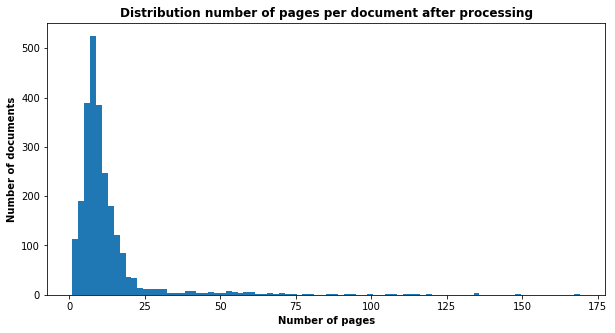

In [23]:
number_of_pages = sorted(np.array(df_overlap.groupby(['filename'], sort=False)['page'].max()))
plt.figure(figsize=(10,5))
plt.hist(number_of_pages, bins = len(set(sorted(number_of_pages))) )
plt.ylabel('Number of documents', fontweight='bold')
plt.xlabel('Number of pages', fontweight='bold')
plt.title("Distribution number of pages per document after processing", fontweight='bold')

As can be observed, the distribution of the number of pages has a very long tail because there are several documents which are extremely long.

Text(0.5,1,'Distribution number or words per page after processing')

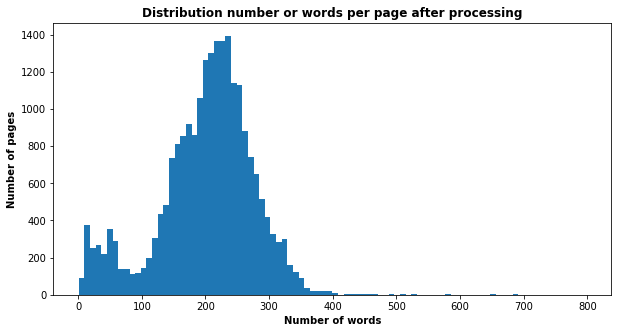

In [24]:
page_length = [len(page) for page in list(df_overlap['text_tokenized_with_numbers'])]
plt.figure(figsize=(10,5))

plt.hist(page_length, bins = int(len(set(page_length))/5))
plt.ylabel('Number of pages', fontweight='bold')
plt.xlabel('Number of words', fontweight='bold')
plt.title("Distribution number or words per page after processing", fontweight='bold')

This distribution of the number of words per page seems binomally distributed, but there are many pages with less than a hundred words. This is due to all documents containing a beginning and end page which are (on average) a lot shorter compared to the other pages in the corpus.

In [12]:
true = [tup[0] for tup in Counter(all_words_true).most_common()[:40]]
false = [tup[0] for tup in Counter(all_words_false).most_common()[:40]]

set(true) - set(false)

{'algemen',
 'besluit',
 'bestemm',
 'del',
 'grot',
 'hierna',
 'koper',
 'meter',
 'open',
 'terrein',
 'vastgesteld',
 'verklaard',
 'verkocht',
 'verkoper',
 'voortdur'}

As you can see, there are a variety of words which occur more often in relevant pages than non-relevant pages, with the words: algemeen, besluit and bestemming being the most obvious ones.

## Results 

For the results there is an initial baseline. This baseline assumes that every first page of a document requires a highlight, and serves as the baseline for all other methods described below. All the metrics implemented are the principle information retrieval measures: precision, recall and f1. 

There are two other methods which were tested as well and measured against this baseline. Both a TF and a TFIDF measure were tested implementing Chi2 for feature reduction, and logistic regression as the binary classifier. Mutual information was also tested, but in earlier experiments the Chi2 performed better compared to the mutual information classifier when looking at the information retrieval measures.

To measure how well both these methods performed, a 5 fold cross validation grid search was performed with a variety of hyperparameters tested. The hyperparemeters which were tested were k (amount of features) and  min df (minimal amount of document frequency) for the vectorization method, and C (the regularization parameter) for the classifier (which in this case is always the logistic regression). This combination of different parameters resulted in 750 fits for both cross validation grid searches.

The results of all the fits are plotted against the f1 measure and the individual hyperparameters parameter values which were tested. The standard deviation and best mean f1 measure over 5 folds is plotted as well. The red line indicates one standard deviation above and below the maximum mean f1 score. The blue line shows the standard deviation of the mean f1 measure over the folds and other values for the remaining hyperparameters. In this way, you can see which hyperparameters have the largest influence on the score.

### Baseline

In [19]:
y_pred_base = []
y_test_base = [str(x)[0] for  x in list(df_overlap.relevant)]
for page in list(df_overlap.page):
    if page == 1:
        y_pred_base.append('T')
    else:
        y_pred_base.append('F')

precision = precision_score(y_test_base, y_pred_base,  average="binary", pos_label="T")
recall = recall_score(y_test_base, y_pred_base,  average="binary", pos_label="T")
f1 = f1_score(y_test_base, y_pred_base, pos_label="T")

table = [['Metric', 'Score'],['Precision', precision],['Recall', recall], ['F1', f1]]
print("Metrics: Baseline for over the whole dataset (no test/train)")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Metrics: Baseline for over the whole dataset (no test/train)


Metric,Score
Precision,0.3561126373626374
Recall,0.15227606461086637
F1,0.21333059041349517


In [58]:
y_pred_base = []
y_test_base = [str(x)[0] for  x in list(df_overlap.relevant)]
for idx,page in enumerate(list(df_overlap.text_tokenized_with_numbers)):    
    if any(word in page for word in ['algemen', 'besluit', 'bestemm', 'centiar', 'del', 'grot', 'hierna', 'percel']):
        y_pred_base.append('T')
    else:
        y_pred_base.append('F')
    
            
precision = precision_score(y_test_base, y_pred_base,  average="binary", pos_label="T")
recall = recall_score(y_test_base, y_pred_base,  average="binary", pos_label="T")
f1 = f1_score(y_test_base, y_pred_base, pos_label="T")

table = [['Metric', 'Score'],['Precision', precision],['Recall', recall], ['F1', f1]]
print("Metrics: Baseline for over the whole dataset (no test/train)")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Metrics: Baseline for over the whole dataset (no test/train)


Metric,Score
Precision,0.2522071254148143
Recall,0.9515709898417198
F1,0.398732924173431


## Comparison dataset with and without split deeds

Here a comparison is made with a 5-fold cross validation for both datasets. One with the splitsingaktes and one without. It illustrates how the scores increase if ambigouity is decreased and therefore indicates how this is essential in improving the classification task.

In [46]:
texts = np.array([' '.join(text) for text in list(df_overlap.text_tokenized_with_numbers)])
labels = np.array(list(df_overlap.relevant))

vec = CountVectorizer()
lr = LogisticRegression(C=10000, max_iter = 1000)
k_best = SelectKBest(k=900)

pipe = make_pipeline(vec, k_best, lr)

scores = cross_validate(pipe, texts, labels, cv = 5, scoring = ['f1', 'recall', 'precision'])

print('Without split deeds')
print('             mean  std')
print('F1:          ' + str(np.mean(scores['test_f1']))[:4] + '  '+ str(np.std(scores['test_f1']))[:6])
print('Precision:   ' + str(np.mean(scores['test_precision']))[:4]+ '  '+  str(np.std(scores['test_precision']))[:6])
print('Recall:      ' + str(np.mean(scores['test_recall']))[:4]+ '  '+ str(np.std(scores['test_recall']))[:6])

C:\Users\tom_v\AppData\Local\Continuum\anaconda2\envs\PythonNieuw\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tom_v\AppData\Local\Continuum\anaconda2\envs\PythonNieuw\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tom_v\AppData\Local\Continuum\anaconda2\envs\PythonNieuw\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tom_v\AppData\Local\Continuum\anaconda2\envs\PythonNieuw\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tom

Without split deeds
             mean  std
F1:          0.66  0.0065
Precision:   0.75  0.0047
Recall:      0.59  0.0077


In [48]:
texts = np.array([' '.join(text) for text in list(df_overlap.text_tokenized_with_numbers)])
labels = np.array(list(df_overlap.relevant))

vec = CountVectorizer()
lr = LogisticRegression(C=10000, max_iter = 1000)
k_best = SelectKBest(k=900)

pipe = make_pipeline(vec, k_best, lr)

scores = cross_validate(pipe, texts, labels, cv = 5, scoring = ['f1', 'recall', 'precision'])

print('With split deeds')
print('             mean  std')
print('F1:          ' + str(np.mean(scores['test_f1']))[:4] + '  '+ str(np.std(scores['test_f1']))[:6])
print('Precision:   ' + str(np.mean(scores['test_precision']))[:4]+ '  '+  str(np.std(scores['test_precision']))[:6])
print('Recall:      ' + str(np.mean(scores['test_recall']))[:4]+ '  '+ str(np.std(scores['test_recall']))[:6])

C:\Users\tom_v\AppData\Local\Continuum\anaconda2\envs\PythonNieuw\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tom_v\AppData\Local\Continuum\anaconda2\envs\PythonNieuw\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tom_v\AppData\Local\Continuum\anaconda2\envs\PythonNieuw\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tom_v\AppData\Local\Continuum\anaconda2\envs\PythonNieuw\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tom

With split deeds
             mean  std
F1:          0.58  0.0110
Precision:   0.74  0.0170
Recall:      0.47  0.0184


## TF Logistic Regression Grid Search

In [2]:
df_tf_grid_search = pd.read_pickle('tf_grid.pickle')

In [5]:
df_tf_grid_search.params[140]

{'dimred__k': 900, 'logistic__C': 10, 'tfidf__min_df': 3}

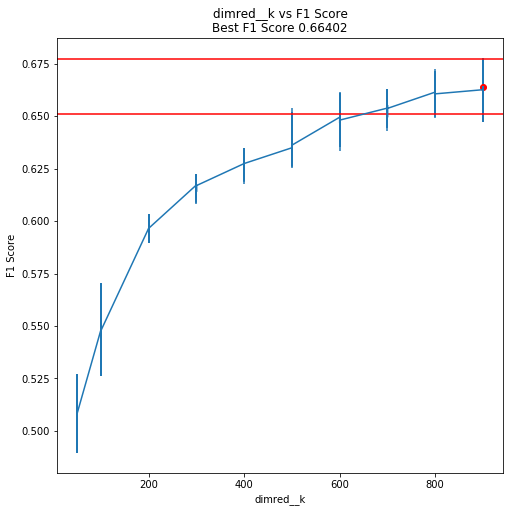

In [53]:
df_to_plot_grid(df_tf_grid_search, 'dimred__k')

Here is a plot of the amount of dimensions against the f1 score for the TF vectorization. The dimensions are all the k best words which were calculated by the Chi2 algorithm for the whole dataset(so not per class). As can be observed, the standard deviation is rather low for all the scores, and at around 800 features the score levels out.

## TFIDF Logistic Regression Grid Search

In [59]:
df_tfidf_grid_search = pd.read_pickle('grid_search_cv5_k900_C10000_df2_f166_with_numbers.pickle')


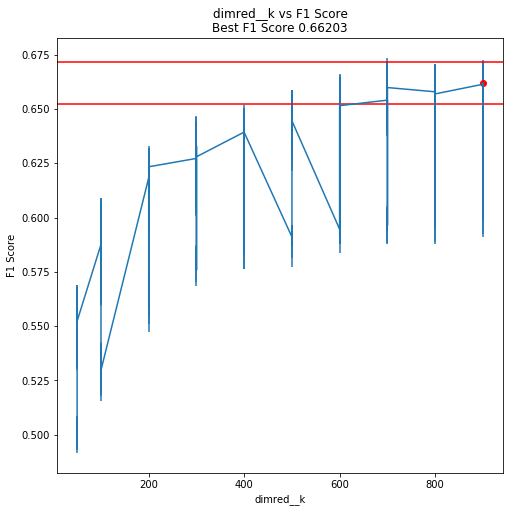

In [18]:
df_to_plot_grid(df_tfidf_grid_search, 'dimred__k')

Here is a plot of the amount of dimensions against the f1 score for the TFIDF vectorization. As can be observed, the standard deviation is rather high for all the scores, and at around 700 features the score levels out. The highest mean average score is slightly lower here compared to the tf method.